# Chargement du dataset Kuzushiji-MNIST

**Motivation :** Kuzushiji-MNIST propose une alternative plus difficile à MNIST. En effet, la plupars des modèles de Deep Learning récents sont capables d'obtenir plus de 99.5% d'accuracy sur MNIST, c'est pourquoi il peut être intéressant d'évaluer un modèle sur des dataset plus challengeant. 

Kuzushiji-MNIST propose 70 000 images de caractères issus de la littérature japonaise classique. A l'instar de MNIST, le dataset original comporte 10 classes de caractères. K-MNIST est également décliné en 2 autres dataset plus difficiles :
- Kuzushiji-49 contient 270,912 images divisées en 49 classes *imbalanced*.
- Kuzushiji-Kanji contient 140 426 images divisées en 3832 classes de caractères très *imbalanced* : certains caractères ne sont présents qu'une et unique fois dans le dataset, rendant impossible un découpage *train* / *valid*.

### Download K-MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
!git clone https://github.com/leopoldmaillard/CapsNet_kmnist.git
%cd CapsNet_kmnist/
%mkdir callbacks

Cloning into 'CapsNet_kmnist'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 87 (delta 43), reused 22 (delta 4), pack-reused 0
Unpacking objects: 100% (87/87), done.
/content/CapsNet_kmnist


In [3]:
X_train = np.load('data/kmnist-train-imgs.npz')['arr_0']
Y_train = np.load('data/kmnist-train-labels.npz')['arr_0']

X_test = np.load('data/kmnist-test-imgs.npz')['arr_0']
Y_test = np.load('data/kmnist-test-labels.npz')['arr_0']

In [4]:
# Preprocess data (normalization)
X_train = (X_train / 256)[...,None].astype('float32')
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)

X_test = (X_test / 256)[...,None].astype('float32')
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=10)

In [5]:
X_train[0].shape

(28, 28, 1)

### CapsNet

In [6]:
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

In [7]:
# All hyperparameters in a single cell
epochs = 10
batch_size = 100
learning_rate = 0.001
decay = 0.9 # to decrease learning rate at each epoch
lam_recon = 0.392 # decoder loss coefficient
n_routings = 3 # number of routing by agreement iterations
n_class = 10

In [8]:
def CapsNet(input_shape, n_class, routings, batch_size):
    
    # input layer
    x = tf.keras.layers.Input(input_shape, batch_size = batch_size)
    
    # layer 1 : regular Convolutionnal layer
    conv1 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (9,9), activation = 'relu', name = 'conv1')(x)
    
    # layer 2 : PrimaryCaps, which is a convolution layer with Squash activation
    # dim_capsule : corresponds to the dimension of the capsule output vector
    # n_channels : number of capsule types
    primarycaps = PrimaryCap(conv1, dim_capsule = 8, n_channels = 32, kernel_size = 9, strides = 2, padding = 'valid')
    
    # layer 3 : CapsuleLayer (involves routing by agreement)
    # each capsule in this layer represents one of the Kuzushiji symbol
    kcaps = CapsuleLayer(num_capsule = n_class, dim_capsule = 16, routings = routings, name = 'kcaps')(primarycaps)
    
    # layer 4 : layer that takes the length of each capsule
    out_caps = Length(name='capsnet')(kcaps)
    
    # Let's build the decoder network
    # 2 reconstructions are performed :
    # - first one is to reconstruct image according to the true label
    # - second one is to reconstruct image according to the vector with maximal length (prediction)
    y = tf.keras.layers.Input((n_class,))
    masked_by_y = Mask()([kcaps, y])
    masked = Mask()(kcaps)
    
    # Dense layers of the decoder architecture as described in the paper
    decoder = tf.keras.models.Sequential(name = 'decoder')
    decoder.add(tf.keras.layers.Dense(512, activation = 'relu', input_dim = 16 * n_class))
    decoder.add(tf.keras.layers.Dense(1024, activation = 'relu'))
    decoder.add(tf.keras.layers.Dense(input_shape[0]*input_shape[1], activation = 'sigmoid'))
    decoder.add(tf.keras.layers.Reshape(input_shape, name = 'out_recon'))
    
    # Models used for training and evaluation
    # train_model involves training of the decoder
    # while evaluation model, given an input x, outputs his prediction and his reconstruction using the trained decoder
    train_model = tf.keras.models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = tf.keras.models.Model(x, [out_caps, decoder(masked)])
                
    return train_model, eval_model

In [9]:
# a custom loss is used for training
def margin_loss(y_true, y_pred):
    loss = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
           0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    
    return tf.reduce_mean(tf.reduce_sum(loss, 1))

In [10]:
log = tf.keras.callbacks.CSVLogger('callbacks/log.csv')

# weigths of the model that has the best validation accuracy are saved during training
checkpoint = tf.keras.callbacks.ModelCheckpoint('callbacks/weights-{epoch:02d}.h5',
                                                monitor = 'val_capsnet_acc', save_best_only=True, 
                                                save_weights_only=True, verbose=1)

# learning rate is reduced during training for optimal gradient descent
lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch : learning_rate * (decay ** epoch))

In [11]:
model, eval_model = CapsNet(input_shape = X_train[0].shape, n_class = n_class, 
                            routings = n_routings, batch_size = batch_size)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(100, 28, 28, 1)]   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (100, 20, 20, 256)   20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (100, 6, 6, 256)     5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (100, 1152, 8)       0           primarycap_conv2d[0][0]          
______________________________________________________________________________________________

In [13]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate), loss=[margin_loss, 'mse'],
              loss_weights=[1, lam_recon], metrics={'capsnet': 'accuracy'})

In [14]:
history = model.fit([X_train, Y_train], [Y_train, X_train], batch_size = batch_size, epochs = epochs,
              validation_data=([X_test, Y_test], [Y_test, X_test]), callbacks = [log, checkpoint, lr_decay])

Epoch 1/10
600/600 [==============================] - 112s 134ms/step - loss: 0.7687 - capsnet_loss: 0.7202 - decoder_loss: 0.1237 - capsnet_accuracy: 0.2112 - val_loss: 0.1713 - val_capsnet_loss: 0.1376 - val_decoder_loss: 0.0861 - val_capsnet_accuracy: 0.8437
Epoch 2/10
600/600 [==============================] - 81s 135ms/step - loss: 0.0845 - capsnet_loss: 0.0525 - decoder_loss: 0.0815 - capsnet_accuracy: 0.9561 - val_loss: 0.1126 - val_capsnet_loss: 0.0812 - val_decoder_loss: 0.0801 - val_capsnet_accuracy: 0.9171
Epoch 3/10
600/600 [==============================] - 80s 134ms/step - loss: 0.0590 - capsnet_loss: 0.0293 - decoder_loss: 0.0757 - capsnet_accuracy: 0.9768 - val_loss: 0.0990 - val_capsnet_loss: 0.0688 - val_decoder_loss: 0.0770 - val_capsnet_accuracy: 0.9271
Epoch 4/10
600/600 [==============================] - 81s 134ms/step - loss: 0.0480 - capsnet_loss: 0.0196 - decoder_loss: 0.0723 - capsnet_accuracy: 0.9866 - val_loss: 0.0927 - val_capsnet_loss: 0.0636 - val_decoder

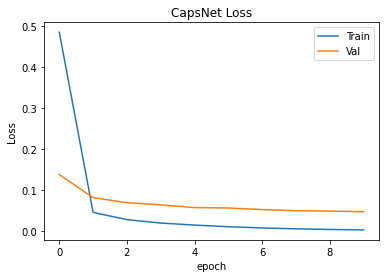

In [20]:
plt.plot(history.history['capsnet_loss'])
plt.plot(history.history['val_capsnet_loss'])
plt.title('CapsNet Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

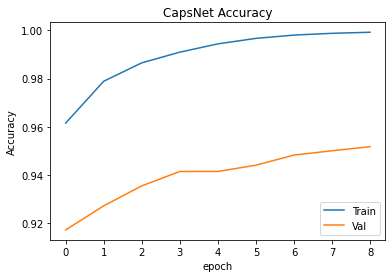

In [25]:
plt.plot(history.history['capsnet_accuracy'][1:])
plt.plot(history.history['val_capsnet_accuracy'][1:])
plt.title('CapsNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()